In [1]:
import pandas as pd
import re
import datetime
import itertools
import aesara.tensor as at
from tqdm import tqdm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib import cm
import matplotlib
import numpy as np
from collections import Counter
from paired_connectivity_analyzer import EEGPairedPermutationAnalyser, DrawEEG
from plotting_utils import plot_compute_sign_differences, draw_edges_by_dict, plot_reproducibility_pattern, plot_reproducibility_by_frequency
import pymc as pm
import arviz as az
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Байесовская иерархическая модель
Считаем что разница для каждого ребра сэмплируется из какого-то общего распределения, которое потом уже на следующем уровне иерархии расходится по полосам

 - сделать функция для сборки датафрейма через список пар каналов
 - оценить для разного количества 

In [2]:
time_now = datetime.datetime.now()
datepath = f"{time_now.day}_{time_now.now().month}_{time_now.hour}h_{time_now.minute}m"

In [5]:
SIZE = 100
df_original = pd.read_csv('eeg_dataframe_nansfilled.csv', index_col=0)
analyzer = EEGPairedPermutationAnalyser(data_df=df_original, num_perm=500, thres=0.025)
analyzer.get_subgroup(size=SIZE)
df = analyzer.df.loc[analyzer.subgroup_ids]
df.head()
df.to_csv(f"./bayes_results/df_{SIZE}sbj_{datepath }.csv")


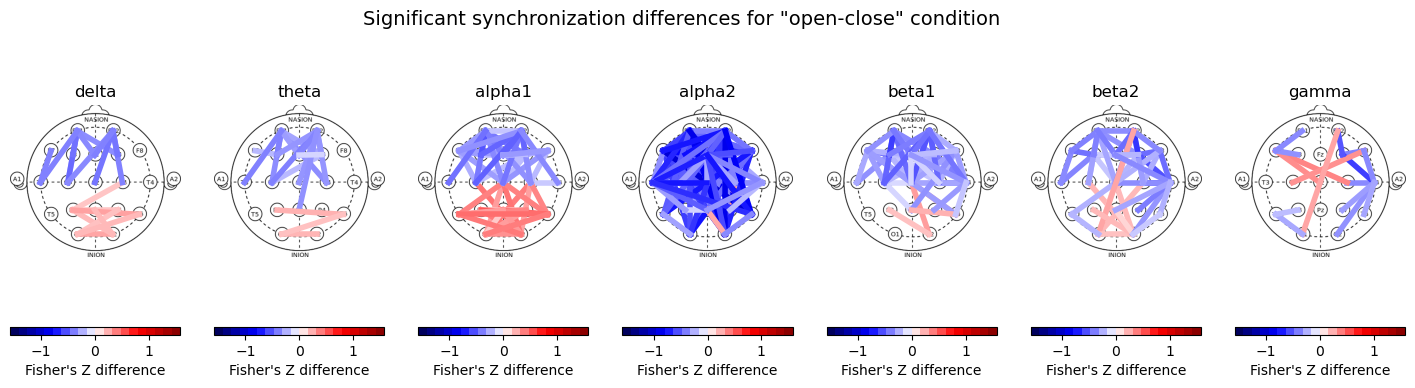

In [6]:
vmin_=-1.5
vmax_=1.5
cmap = cm.seismic
obj = plot_compute_sign_differences(idxs = analyzer.subgroup_ids , band=[1,2,3,4,5,6,7], num_perms=10000, thres=0.001,
                                    title=None, cmap=cmap, vmin=vmin_, vmax=vmax_, figsize=(18, 4))


In [7]:
key_bands = {'delta':0, 'theta':1,'alpha1':2, 'alpha2':3, 'beta1':4,'beta2':5,'gamma':6}


def precomute_candidate_pairs(analyzer, thres = 0.001):
    dict_list = [analyzer.compute_sign_differences(idxs=analyzer.subgroup_ids, band=band,
                                 num_perms=10000, thres=0.001) for band in range(1,8)]

    cand_list_pos = [list(dict_list[i]['chan_names'][dict_list[i]['chan_diffs']>0]) for i in range(0,7)]
    pos_chans = list(set(itertools.chain.from_iterable(cand_list_pos)))
    cand_list_neg = [list(dict_list[i]['chan_names'][dict_list[i]['chan_diffs']<0]) for i in range(0,7)]
    neg_chans = list(set(itertools.chain.from_iterable(cand_list_neg)))
    all_chans = list(set(pos_chans).union(set(neg_chans)))
    return {'all': all_chans, 'pos': pos_chans, 'neg': neg_chans}

def prepare_df_with_chan_pairs(chan_pairs, df=None):
    chan_df = []
    for chan_pair in chan_pairs:
        chan_cols = [col for col in df.columns if chan_pair in col]
        df_pair = df[chan_cols]
        open_name = [col for col in chan_cols if "fo" in col]
        close_name = [col for col in chan_cols if "fz" in col]
        diffs = df_pair[open_name].values-df_pair[close_name].values
        df_diffs = pd.DataFrame(diffs, columns = list(key_bands.keys()), index = df_pair.index)
        df_diffs = df_diffs.reset_index()
        melted_df_diffs = pd.melt(df_diffs, var_name="band", value_name='diff', id_vars="index" )
        melted_df_diffs['band_id'] = melted_df_diffs['band'].map(key_bands)
        melted_df_diffs['subj_id'] = pd.Categorical(melted_df_diffs['index']).codes
        melted_df_diffs["chans"] = chan_pair
        chan_df.append(melted_df_diffs)
    chan_df = pd.concat(chan_df)
    chan_df['chans_id'] = pd.Categorical(chan_df['chans']).codes
    return chan_df.reset_index(drop=True)


def compute_individual_model(chan_df=None, savefile = f'./bayes_results/trace_ind_{SIZE}sbj_{datepath}.nc'):
    
    coords = {"band_type": list(key_bands.keys()), "sub_id": list(df.index), 
          "obs_id": np.arange(chan_df.index.size), 'chans': chan_pairs}

    with pm.Model(coords=coords) as model_indep_ind:
    
        #define ids 
        band_type = pm.Data("band_type", chan_df.band_id.values, dims = "obs_id", mutable=False)
        chan_pair = pm.Data("chan_pair", chan_df.chans_id.values, dims = "obs_id", mutable=False)
        ind_ids = pm.Data("inds", chan_df.subj_id.values, dims = "obs_id", mutable=False)
        mu = pm.Normal('mu', mu=0, sigma=1, dims=("band_type", "chans"))
        sigma_mu = pm.Exponential("sigma_mu", 1.0, dims=("band_type", "chans"))
    
         #individual differences
        sigma_shift = pm.Exponential("sigma_shift", 1.0)
        z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sigma=1.0, dims="sub_id")
        shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims="sub_id") 
    
        diffs = pm.Normal('diff', mu=mu[band_type,chan_pair]+ shift_ind[ind_ids], sigma=sigma_mu[band_type, chan_pair], observed=chan_df['diff'].values, dims = "obs_id")
        trace_indep_ind = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500) 
        trace_indep_ind.to_netcdf(savefile)
    return trace_indep_ind
        

In [8]:
def draw_positive(df=None, effect_size=1, color="ef_size"):
    cmap = cm.YlOrRd
    vmax_=1
    vmin_=0
    fig, axs = plt.subplots(nrows=1, ncols=len(key_bands.keys()), figsize=(18, 4))
    draw_obj = DrawEEG()
    title_list = [f"{band}" for band in key_bands.keys()]
    for band, ind in key_bands.items():
        band_df = df[df.band==band]
        band_df_cut = band_df[(band_df.effect_size>effect_size) & (band_df['hdi_2.5%']>0)]
        pair_names = list(band_df_cut.chan_pair)
        
        if color=="ef_size":
            values_color = np.abs(band_df_cut.effect_size.values) #band_df_cut.effect_size.values
            values_color[values_color<vmin_]=vmin_
            values_color[values_color>vmax_]=vmax_
            values_width = np.abs(band_df_cut["mean"].values)
        else:
            values_color = np.abs(band_df_cut["mean"].values) #band_df_cut.effect_size.values
            values_color[values_color<vmin_]=vmin_
            values_color[values_color>vmax_]=vmax_
            values_width = band_df_cut.effect_size.values
            
        draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=True, normalize_width=True, vmin=vmin_, vmax=vmax_,
                        title=title_list[ind], ax=axs[ind], cmap=cmap)
        divider = make_axes_locatable(draw_obj.ax)
        cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
        draw_obj.fig.add_axes(cax)

        if len(pair_names) > 0:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
            cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, values=cvalues,
                                            orientation="horizontal")
        else:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
        cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,  values=cvalues,
                                                orientation="horizontal")
def draw_negative(df=None, effect_size=1, color="ef_size"):
    cmap = cm.Blues
    vmax_=1
    vmin_=0
    fig, axs = plt.subplots(nrows=1, ncols=len(key_bands.keys()), figsize=(18, 4))
    draw_obj = DrawEEG()
    title_list = [f"{band}" for band in key_bands.keys()]
    for band, ind in key_bands.items():
        band_df = df[df.band==band]
        band_df_cut = band_df[(band_df.effect_size<-effect_size) & (band_df['hdi_97.5%']<0)]
        pair_names = list(band_df_cut.chan_pair)

        if color=="ef_size":
            values_color = np.abs(band_df_cut.effect_size.values) #band_df_cut.effect_size.values
            values_color[values_color<vmin_]=vmin_
            values_color[values_color>vmax_]=vmax_
            values_width = np.abs(band_df_cut["mean"].values)
        else:
            values_color = np.abs(band_df_cut["mean"].values) #band_df_cut.effect_size.values
            values_color[values_color<vmin_]=vmin_
            values_color[values_color>vmax_]=vmax_
            values_width = np.abs(band_df_cut.effect_size.values)
        
        draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=True, normalize_width=True, vmin=vmin_, vmax=vmax_,
                        title=title_list[ind], ax=axs[ind], cmap=cmap)
        divider = make_axes_locatable(draw_obj.ax)
        cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
        draw_obj.fig.add_axes(cax)

        if len(pair_names) > 0:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
            cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, values=cvalues,
                                            orientation="horizontal")
        else:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
        cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,  values=cvalues,
                                                orientation="horizontal")        

In [9]:
chan_dict = precomute_candidate_pairs(analyzer, thres = 0.001)

In [10]:
print(len(chan_dict['all']))
chan_pairs=chan_dict['all']
chan_df = prepare_df_with_chan_pairs(chan_pairs, df=df)

122


In [11]:
chan_df.head()

,index,band,diff,band_id,subj_id,chans,chans_id
0,mom_,delta,0.049087,0,54,T6/O1,120
1,gor_,delta,0.299721,0,22,T6/O1,120
2,bls_,delta,0.017272,0,6,T6/O1,120
3,vls_,delta,0.379009,0,94,T6/O1,120
4,pet_,delta,0.526864,0,65,T6/O1,120


In [12]:
trace_indep_ind = compute_individual_model(chan_df=chan_df)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 94100
Interrupted at 94,099 [47%]: Average Loss = 96,795
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, sigma_shift, z_shift_ind]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 1337 seconds.


In [73]:
#trace_indep_ind = az.from_netcdf('./bayes_results/trace_ind_40sbj_25_11_9h_35m.nc')

In [13]:
mu_chan_pair_df = az.summary(trace_indep_ind, var_names=[ "mu"], hdi_prob=0.95, round_to=3, kind = 'stats')
result_list = [re.search(r"mu\[(\w+), (\w+\/\w+)\]", ind) for ind in mu_chan_pair_df.index]
mu_chan_pair_df["band"] = [result[1] for result in result_list]
mu_chan_pair_df["chan_pair"] = [result[2] for result in result_list]
sigma_chan_pair_df = az.summary(trace_indep_ind, var_names=[ "sigma_mu"], hdi_prob=0.95, round_to=3, 
                             kind = 'stats')
mu_chan_pair_df["sigma_mu"] = sigma_chan_pair_df["mean"].values
mu_chan_pair_df["effect_size"]  = mu_chan_pair_df["mean"]/mu_chan_pair_df["sigma_mu"]
mu_chan_pair_df.head()

,mean,sd,hdi_2.5%,hdi_97.5%,band,chan_pair,sigma_mu,effect_size
"mu[delta, T6/O1]",0.039,0.051,-0.059,0.136,delta,T6/O1,0.479,0.081420
"mu[delta, T5/O2]",-0.017,0.052,-0.116,0.087,delta,T5/O2,0.493,-0.034483
"mu[delta, C4/T6]",0.058,0.080,-0.092,0.220,delta,C4/T6,0.793,0.073140
"mu[delta, T5/P3]",0.156,0.081,-0.005,0.310,delta,T5/P3,0.784,0.198980
"mu[delta, C4/T4]",-0.042,0.048,-0.133,0.056,delta,C4/T4,0.446,-0.094170


In [14]:
mu_chan_pair_df[mu_chan_pair_df.effect_size>0.6]

,mean,sd,hdi_2.5%,hdi_97.5%,band,chan_pair,sigma_mu,effect_size
"mu[delta, Fp1/Fz]",0.295,0.049,0.202,0.392,delta,Fp1/Fz,0.458,0.644105
"mu[theta, Fp1/Fz]",0.249,0.043,0.164,0.335,theta,Fp1/Fz,0.398,0.625628
"mu[alpha1, Fp1/Fz]",0.346,0.044,0.261,0.434,alpha1,Fp1/Fz,0.415,0.833735
"mu[alpha1, Cz/C4]",0.414,0.062,0.292,0.534,alpha1,Cz/C4,0.586,0.706485
"mu[alpha1, Fp2/F7]",0.523,0.086,0.359,0.693,alpha1,Fp2/F7,0.862,0.606729
"mu[alpha1, Fp1/Fp2]",0.321,0.049,0.224,0.414,alpha1,Fp1/Fp2,0.455,0.705495
"mu[alpha1, F8/O1]",0.460,0.071,0.315,0.594,alpha1,F8/O1,0.677,0.679468
"mu[alpha1, P3/P4]",0.417,0.059,0.298,0.531,alpha1,P3/P4,0.590,0.706780
"mu[beta2, Cz/C4]",0.230,0.040,0.156,0.312,beta2,Cz/C4,0.369,0.623306


In [15]:
mu_chan_pair_df.to_csv(f'./bayes_results/mu_df_{SIZE}sbj_{datepath}.csv')

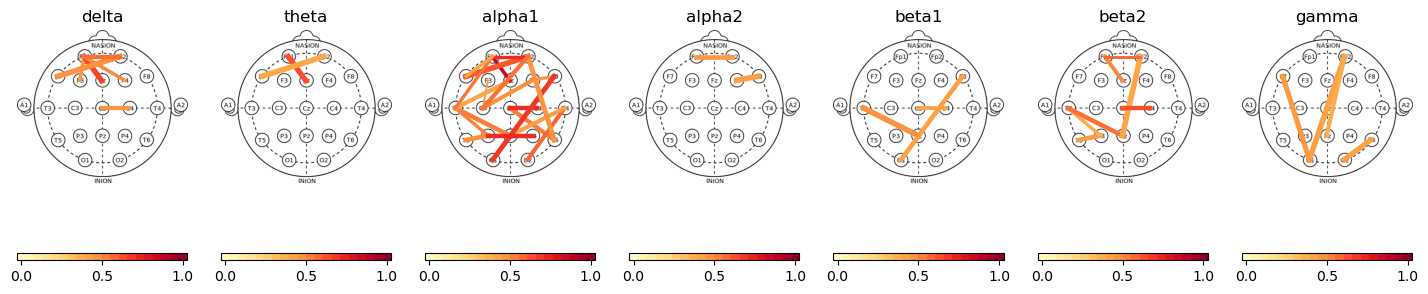

In [16]:
draw_positive(df=mu_chan_pair_df, effect_size=0.4, color="ef_size")

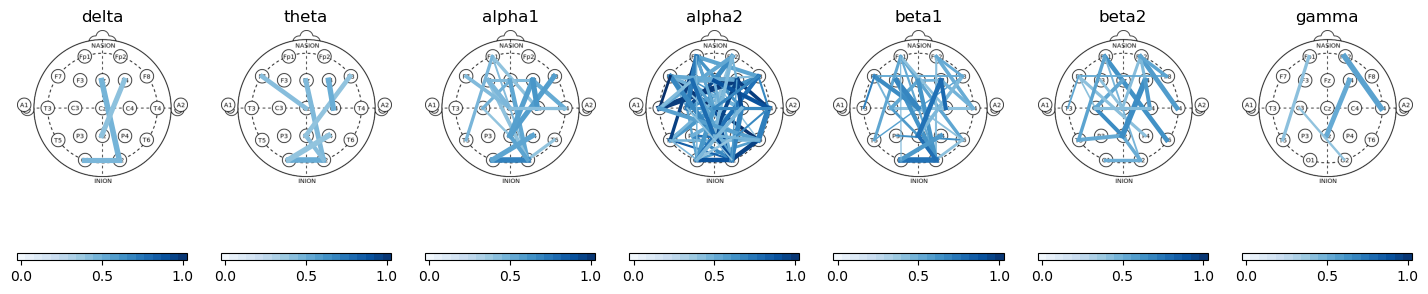

In [17]:
draw_negative(df=mu_chan_pair_df, effect_size=0.4, color="ef_size")

In [31]:
with pm.Model(coords=coords) as model_indep_ind:
    
    #define ids 
    band_type = pm.Data("band_type", chan_df.band_id.values, dims = "obs_id", mutable=False)
    chan_pair = pm.Data("chan_pair", chan_df.chans_id.values, dims = "obs_id", mutable=False)
    ind_ids = pm.Data("inds", chan_df.subj_id.values, dims = "obs_id", mutable=False)
    mu = pm.Normal('mu', mu=0, sigma=1, dims=("band_type", "chans"))
    sigma_mu = pm.Exponential("sigma_mu", 1.0, dims=("band_type", "chans"))
    
     #individual differences
    sigma_shift = pm.Exponential("sigma_shift", 1.0)
    z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sigma=1.0, dims="sub_id")
    shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims="sub_id") 
    
    diffs = pm.Normal('diff', mu=mu[band_type,chan_pair]+ shift_ind[ind_ids], sigma=sigma_mu[band_type, chan_pair], observed=chan_df['diff'].values, dims = "obs_id")
    trace_indep_ind = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500) 
    trace_indep_ind.to_netcdf("filename.nc")
    

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 180100
Interrupted at 180,099 [90%]: Average Loss = 41,481
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma_mu, sigma_shift, z_shift_ind]


Sampling 4 chains for 500 tune and 2_000 draw iterations (2_000 + 8_000 draws total) took 648 seconds.


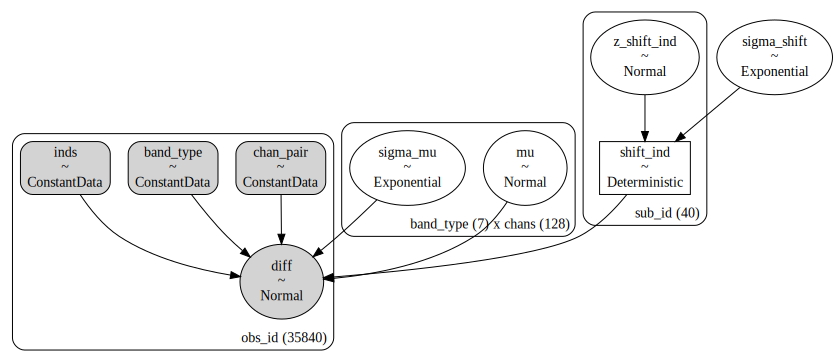

In [110]:
pm.model_to_graphviz(model_indep_ind)

In [27]:
az.summary(trace_indep_ind,var_names=[ "mu"], hdi_prob=0.9,round_to=2)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"mu[delta, C4/T5]",0.16,0.12,-0.03,0.36,0.0,0.0,3154.20,5020.05,1.00
"mu[delta, P4/O1]",0.31,0.12,0.12,0.52,0.0,0.0,4079.61,5554.14,1.00
"mu[delta, Pz/P4]",0.06,0.09,-0.08,0.22,0.0,0.0,2344.26,3685.17,1.00
"mu[delta, Cz/O2]",0.15,0.09,0.01,0.29,0.0,0.0,1852.01,4589.13,1.00
"mu[delta, Cz/O1]",0.05,0.15,-0.19,0.29,0.0,0.0,4663.27,5817.04,1.00
...,...,...,...,...,...,...,...,...,...
"mu[gamma, C3/O2]",-0.22,0.09,-0.38,-0.07,0.0,0.0,1831.14,4565.44,1.00
"mu[gamma, Fp2/F7]",-0.25,0.11,-0.43,-0.08,0.0,0.0,2239.11,4556.84,1.00
"mu[gamma, P3/O2]",-0.19,0.08,-0.32,-0.05,0.0,0.0,1734.85,3016.44,1.00
"mu[gamma, Cz/T5]",-0.19,0.08,-0.31,-0.06,0.0,0.0,1415.73,4554.26,1.01


In [63]:
mu_chan_pair_df = az.summary(trace_indep_ind, var_names=[ "mu"], hdi_prob=0.95, round_to=3, kind = 'stats')
mu_chan_pair_df["effect_size"] = mu_chan_pair_df['mean']/mu_chan_pair_df['sd']
result_list = [re.search(r"mu\[(\w+), (\w+\/\w+)\]", ind) for ind in mu_chan_pair_df.index]
mu_chan_pair_df["band"] = [result[1] for result in result_list]
mu_chan_pair_df["chan_pair"] = [result[2] for result in result_list]

In [64]:
mu_chan_pair_df.to_csv("23_11_mu_chan_pair_df.csv")

In [65]:
mu_chan_pair_df

,mean,sd,hdi_2.5%,hdi_97.5%,effect_size,band,chan_pair
"mu[delta, Fz/F8]",0.068,0.084,-0.096,0.235,0.809524,delta,Fz/F8
"mu[delta, C4/P3]",0.002,0.089,-0.173,0.177,0.022472,delta,C4/P3
"mu[delta, C3/Pz]",0.222,0.124,-0.024,0.457,1.790323,delta,C3/Pz
"mu[delta, T3/C4]",0.372,0.128,0.121,0.623,2.906250,delta,T3/C4
"mu[delta, F7/O2]",0.137,0.070,0.003,0.280,1.957143,delta,F7/O2
...,...,...,...,...,...,...,...
"mu[gamma, Fp2/O2]",-0.136,0.089,-0.307,0.037,-1.528090,gamma,Fp2/O2
"mu[gamma, P3/O2]",-0.137,0.071,-0.265,0.008,-1.929577,gamma,P3/O2
"mu[gamma, Fp1/Fz]",-0.254,0.115,-0.471,-0.023,-2.208696,gamma,Fp1/Fz
"mu[gamma, F3/T3]",-0.184,0.114,-0.402,0.040,-1.614035,gamma,F3/T3


In [66]:
band_df = mu_chan_pair_df[mu_chan_pair_df.band=="delta"]
band_df.head()


,mean,sd,hdi_2.5%,hdi_97.5%,effect_size,band,chan_pair
"mu[delta, Fz/F8]",0.068,0.084,-0.096,0.235,0.809524,delta,Fz/F8
"mu[delta, C4/P3]",0.002,0.089,-0.173,0.177,0.022472,delta,C4/P3
"mu[delta, C3/Pz]",0.222,0.124,-0.024,0.457,1.790323,delta,C3/Pz
"mu[delta, T3/C4]",0.372,0.128,0.121,0.623,2.906250,delta,T3/C4
"mu[delta, F7/O2]",0.137,0.070,0.003,0.280,1.957143,delta,F7/O2


In [70]:
band_df['hdi_2.5%']>0

mu[delta, Fz/F8]     False
mu[delta, C4/P3]     False
mu[delta, C3/Pz]     False
mu[delta, T3/C4]      True
mu[delta, F7/O2]      True
                     ...  
mu[delta, Fp2/O2]    False
mu[delta, P3/O2]     False
mu[delta, Fp1/Fz]    False
mu[delta, F3/T3]     False
mu[delta, F7/O1]     False
Name: hdi_2.5%, Length: 128, dtype: bool

In [99]:
band_df_cut = band_df[(band_df.effect_size<-2)& (band_df['hdi_97.5%']<0)]

In [100]:
band_df_cut

,mean,sd,hdi_2.5%,hdi_97.5%,effect_size,band,chan_pair
"mu[delta, F4/O1]",-0.266,0.104,-0.475,-0.065,-2.557692,delta,F4/O1
"mu[delta, Fp1/F4]",-0.203,0.080,-0.353,-0.040,-2.537500,delta,Fp1/F4
"mu[delta, F8/T4]",-0.356,0.146,-0.639,-0.064,-2.438356,delta,F8/T4
"mu[delta, F3/Cz]",-0.315,0.153,-0.612,-0.020,-2.058824,delta,F3/Cz
"mu[delta, Fp2/F7]",-0.388,0.188,-0.749,-0.011,-2.063830,delta,Fp2/F7
"mu[delta, F4/T3]",-0.501,0.155,-0.820,-0.215,-3.232258,delta,F4/T3
"mu[delta, Fp1/F7]",-0.410,0.168,-0.731,-0.069,-2.440476,delta,Fp1/F7
"mu[delta, Pz/T6]",-0.424,0.168,-0.754,-0.097,-2.523810,delta,Pz/T6
"mu[delta, F4/Cz]",-0.299,0.126,-0.546,-0.052,-2.373016,delta,F4/Cz
"mu[delta, Fz/C3]",-0.490,0.137,-0.760,-0.220,-3.576642,delta,Fz/C3


In [84]:
key_bands.keys()

dict_keys(['delta', 'theta', 'alpha1', 'alpha2', 'beta1', 'beta2', 'gamma'])

In [104]:
def draw_positive(df=None, effect_size=1):
    cmap = cm.YlOrRd
    vmax_=1
    vmin_=0
    fig, axs = plt.subplots(nrows=1, ncols=len(key_bands.keys()), figsize=(18, 4))
    draw_obj = DrawEEG()
    title_list = [f"{band}" for band in key_bands.keys()]
    for band, ind in key_bands.items():
        band_df = df[df.band==band]
        band_df_cut = band_df[(band_df.effect_size>effect_size) & (band_df['hdi_2.5%']>0)]
        pair_names = list(band_df_cut.chan_pair)

        values_color = np.abs(band_df_cut["mean"].values) #band_df_cut.effect_size.values
        values_color[values_color<vmin_]=vmin_
        values_color[values_color>vmax_]=vmax_
        values_width = band_df_cut.effect_size.values
        draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=True, normalize_width=True, vmin=vmin_, vmax=vmax_,
                        title=title_list[ind], ax=axs[ind], cmap=cmap)
        divider = make_axes_locatable(draw_obj.ax)
        cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
        draw_obj.fig.add_axes(cax)

        if len(pair_names) > 0:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
            cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, values=cvalues,
                                            orientation="horizontal")
        else:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
        cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,  values=cvalues,
                                                orientation="horizontal")
def draw_negative(df=None, effect_size=1):
    cmap = cm.Blues
    vmax_=1
    vmin_=0
    fig, axs = plt.subplots(nrows=1, ncols=len(key_bands.keys()), figsize=(18, 4))
    draw_obj = DrawEEG()
    title_list = [f"{band}" for band in key_bands.keys()]
    for band, ind in key_bands.items():
        band_df = df[df.band==band]
        band_df_cut = band_df[(band_df.effect_size<-effect_size) & (band_df['hdi_97.5%']<0)]
        pair_names = list(band_df_cut.chan_pair)

        values_color = np.abs(band_df_cut["mean"].values) #band_df_cut.effect_size.values
        values_color[values_color<vmin_]=vmin_
        values_color[values_color>vmax_]=vmax_
        values_width = np.abs(band_df_cut.effect_size.values)
        draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=True, normalize_width=True, vmin=vmin_, vmax=vmax_,
                        title=title_list[ind], ax=axs[ind], cmap=cmap)
        divider = make_axes_locatable(draw_obj.ax)
        cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
        draw_obj.fig.add_axes(cax)

        if len(pair_names) > 0:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
            cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap, values=cvalues,
                                            orientation="horizontal")
        else:
            cvalues = list(np.linspace(vmin_, vmax_, 20))
        cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cmap,  values=cvalues,
                                                orientation="horizontal")        

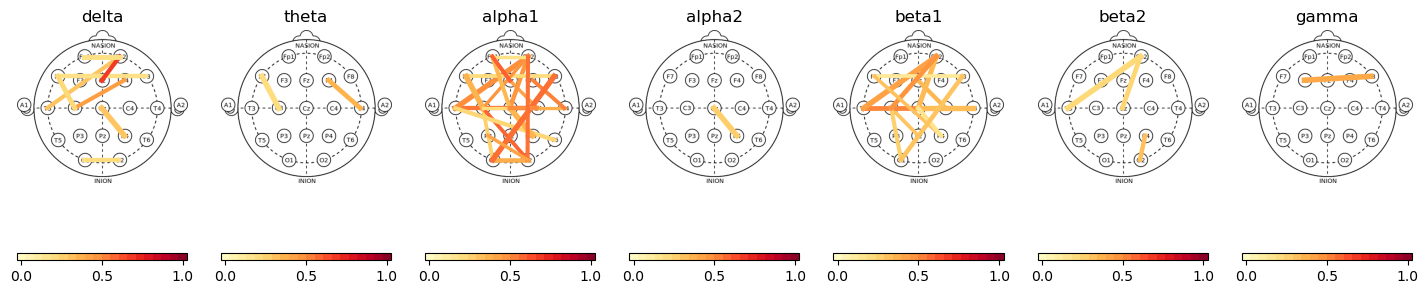

In [117]:
draw_positive(df=mu_chan_pair_df, effect_size=3)

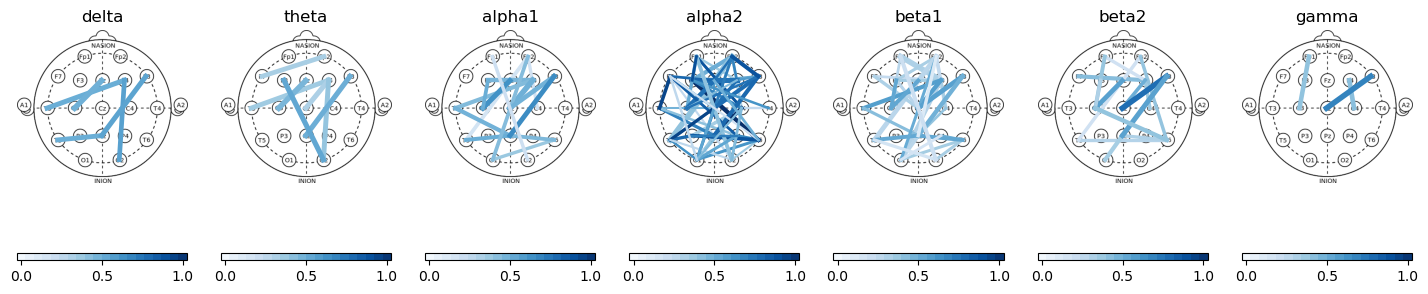

In [118]:
draw_negative(df=mu_chan_pair_df, effect_size=3)

## Model 1
Pooled model without band and individual differences

In [ ]:
coords = {"band_type": list(key_bands.keys()), "sub_id": list(df.index), 
          "obs_id": np.arange(chan_df.index.size), 'chans': chan_pairs}

In [ ]:
with pm.Model(coords=coords) as model_indep:
    
    #define ids 
    band_type = pm.Data("band_type", chan_df.band_id.values, dims = "obs_id", mutable=False)
    chan_pair = pm.Data("chan_pair", chan_df.chans_id.values, dims = "obs_id", mutable=False)
    ind_ids = pm.Data("inds", chan_df.subj_id.values, dims = "obs_id", mutable=False)
    mu = pm.Normal('mu', mu=0, sigma=1, dims=("band_type", "chans"))
    sigma_mu = pm.Exponential("sigma_mu", 1.0, dims=("band_type", "chans"))
    diffs = pm.Normal('diff', mu=mu[band_type,chan_pair], sigma=sigma_mu[band_type, chan_pair], observed=chan_df['diff'].values, dims = "obs_id")
    trace_indep = pm.sample(5000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=1000)

In [ ]:
print(f"Waic: {az.waic(trace_indep)}")
#az.summary(trace_indep,var_names=[ "mu"], round_to=2)

## Model with individual differences

In [ ]:
with pm.Model(coords=coords) as model_indep_ind:
    
    #define ids 
    band_type = pm.Data("band_type", chan_df.band_id.values, dims = "obs_id", mutable=False)
    chan_pair = pm.Data("chan_pair", chan_df.chans_id.values, dims = "obs_id", mutable=False)
    ind_ids = pm.Data("inds", chan_df.subj_id.values, dims = "obs_id", mutable=False)
    mu = pm.Normal('mu', mu=0, sigma=1, dims=("band_type", "chans"))
    sigma_mu = pm.Exponential("sigma_mu", 1.0, dims=("band_type", "chans"))
    
     #individual differences
    sigma_shift = pm.Exponential("sigma_shift", 1.0)
    z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sigma=1.0, dims="sub_id")
    shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims="sub_id") 
    
    diffs = pm.Normal('diff', mu=mu[band_type,chan_pair]+ shift_ind[ind_ids], sigma=sigma_mu[band_type, chan_pair], observed=chan_df['diff'].values, dims = "obs_id")
    trace_indep_ind = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500)    
    
   

In [ ]:
print(f"Waic: {az.waic(trace_indep_ind)}")
#az.summary(trace_indep_ind,var_names=[ "mu"], hdi_prob=0.9,round_to=2)

## Multilevel model with centered priors, shrinkage by channel 
with individual differences



In [ ]:
#mu_global = pm.Normal('mu_global', mu=0, sigma=1, dims="band_type")

In [111]:
with pm.Model(coords=coords) as model_indep_ind_h:
    
    #define ids 
    
    band_type = pm.Data("band_type", chan_df.band_id.values, dims = "obs_id", mutable=False)
    chan_pair = pm.Data("chan_pair", chan_df.chans_id.values, dims = "obs_id", mutable=False)
    ind_ids = pm.Data("inds", chan_df.subj_id.values, dims = "obs_id", mutable=False)
    
    #hierarhical, shrinkage by channel  
    mu_chan= pm.Normal('mu_chan', mu=0, sigma=1, dims="chans")
    
    mu = pm.Normal('mu', mu=mu_chan, sigma=1, dims=("band_type", "chans"))
    sigma_mu = pm.Exponential("sigma_mu", 1.0, dims=("band_type", "chans"))
    
     #individual differences
    sigma_shift = pm.Exponential("sigma_shift", 1.0)
    z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sigma=1.0, dims="sub_id")
    shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims="sub_id") 
    
    diffs = pm.Normal('diff', mu=mu[band_type,chan_pair]+ shift_ind[ind_ids], sigma=sigma_mu[band_type, chan_pair], observed=chan_df['diff'].values, dims = "obs_id")
   # trace_indep_ind_h = pm.sample(2000,
   #                   target_accept=0.9,
   #                   init='advi+adapt_diag',
   #                   tune=500)    
    

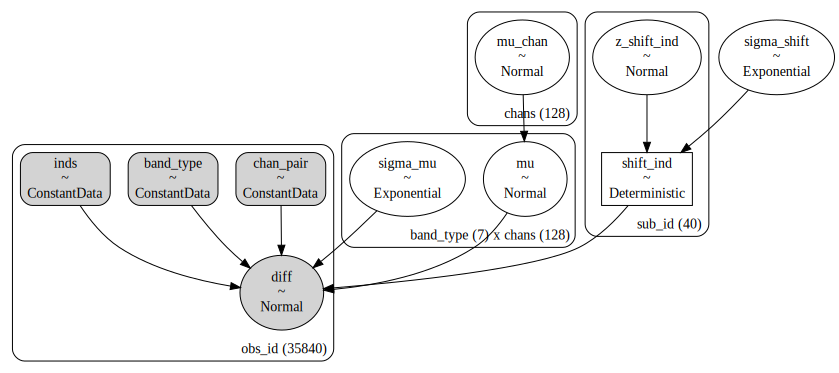

In [112]:
pm.model_to_graphviz(model_indep_ind_h)

In [ ]:
print(f"Waic: {az.waic(trace_indep_ind_h)}")
#az.summary(trace_indep_ind_h,var_names=[ "mu_chan"], hdi_prob=0.9, round_to=2)

In [ ]:
mu_df = az.summary(trace_indep_ind_h, var_names=[ "mu_chan"], hdi_prob=0.95, round_to=2, kind = 'stats')

In [ ]:
mu_chan_pair_df = az.summary(trace_indep_ind_h, var_names=[ "mu"], hdi_prob=0.9, round_to=3, kind = 'stats')
mu_chan_pair_df["effect_size"] = mu_chan_pair_df['mean']/mu_chan_pair_df['sd']
result_list = [re.search(r"mu\[(\w+), (\w+\/\w+)\]", ind) for ind in mu_chan_pair_df.index]
mu_chan_pair_df["band"] = [result[1] for result in result_list]
mu_chan_pair_df["chan_pair"] = [result[2] for result in result_list]

In [ ]:
mu_chan_pair_df.head()

In [ ]:
band_df = mu_chan_pair_df[mu_chan_pair_df.band=="delta"]

In [ ]:
band_df

In [ ]:
#draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=True, normalize_width=False, vmin=vmin, vmax=vmax,
                        title=title, ax=ax, cmap=cm.seismic)

In [ ]:
draw_obj = DrawEEG()
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
pair_names = list(band_df.chan_pair)
vmax_=3
vmin_=-3
values_color = band_df.effect_size.values
values_color[values_color<vmin_]=vmin_
values_color[values_color>vmax_]=vmax_
values_width = np.abs(values_color)
draw_obj.draw_edges(pair_names=pair_names, values_color=values_color,
                        values_width=values_width, normalize_values=False, normalize_width=True, vmin=vmin_, vmax=vmax_,
                        title="Hooo", ax=axs, cmap=cm.seismic)
divider = make_axes_locatable(draw_obj.ax)
cax = divider.new_vertical(size="5%", pad=0.7, pack_start=True)
draw_obj.fig.add_axes(cax)

if len(pair_names) > 0:

        #cvalues = sorted([min(values_color)-0.01]+list(values_color)+[max(values_color)+0.01])
    cvalues = list(np.linspace(vmin_, vmax_, 20))
    cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cm.seismic, values=cvalues,
                                            orientation="horizontal")
else:
    cvalues = list(np.linspace(vmin_, vmax_, 20))
    cbar = matplotlib.colorbar.ColorbarBase(ax=cax, cmap=cm.seismic,  values=cvalues,
                                                orientation="horizontal")

In [ ]:
values_color[values_color<-vmax_]

In [ ]:
with pm.Model(coords=coords) as model_band:
    
    band_type = pm.Data("band_type", melted_df_diffs.band_id.values, dims = "obs_id", mutable=False)
    #global hierarchical prior
    #mu_diff = pm.Normal('mu_global', mu=0, sigma=1)
    #sigma_diff = pm.HalfCauchy('sigma_global', beta=10)   
    
    mu_bands = pm.Normal("mu_bands", mu = 0, sigma = 10, dims = "BandType" )
    sigma_bands = pm.Exponential("sigma", 1.0)
    
    diff = pm.Normal('diff', mu=mu_bands[band_type], sigma=sigma_bands, observed=melted_df_diffs['diff'].values, dims = "obs_id")
    trace_band = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500)

In [ ]:
print(f"Waic: {az.waic(trace_band)}")
az.summary(trace_band,var_names=[ "mu_bands"], round_to=2)

In [ ]:
-0.14/0.03

## Multilevel model with global prior

In [ ]:
with pm.Model(coords=coords) as model_band_h:
    
    band_type = pm.Data("band_type", melted_df_diffs.band_id.values, dims = "obs_id", mutable=False)
    #global hierarchical prior
    mu_global = pm.Normal('mu_global', mu=0, sigma=1)
    sigma_global = pm.HalfCauchy('sigma_global', beta=10)   
    
    mu_bands = pm.Normal("mu_bands", mu = mu_global, sigma = sigma_global, dims = "BandType" )
    sigma_bands = pm.Exponential("sigma", 1.0)
    
    diff = pm.Normal('diff', mu=mu_bands[band_type], sigma=sigma_bands, observed=melted_df_diffs['diff'].values, dims = "obs_id")
    trace_band_h = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500)

In [ ]:
print(f"Waic: {az.waic(trace_band_h)}")
az.summary(trace_band_h,var_names=[ "mu_global","mu_bands"], round_to=2)

## Multilevel with individual differences

In [ ]:
melted_df_diffs

In [ ]:
coords.keys()

In [ ]:
with pm.Model(coords=coords) as model_band_h_ind:
    
    band_type = pm.Data("band_type", melted_df_diffs.band_id.values, dims = "obs_id", mutable=False)
    ind_ids = pm.Data("inds", melted_df_diffs.subj_id.values, dims = "obs_id", mutable=False)

    #global hierarchical prior
    mu_global = pm.Normal('mu_global', mu=0, sigma=1)
    sigma_global = pm.HalfCauchy('sigma_global', beta=10)   
    
    mu_bands = pm.Normal("mu_bands", mu = mu_global, sigma = sigma_global, dims = "BandType" )
    sigma_bands = pm.Exponential("sigma", 1.0)
    
    #individual differences
    sigma_shift = pm.Exponential("sigma_shift", 1.0)
    z_shift_ind = pm.Normal("z_shift_ind", mu=0.0, sigma=1.0, dims="SId")
    shift_ind = pm.Deterministic("shift_ind", z_shift_ind * sigma_shift, dims="SId") 
    
    diff = pm.Normal('diff', mu=mu_bands[band_type]+shift_ind[ind_ids], sigma=sigma_bands, observed=melted_df_diffs['diff'].values, dims = "obs_id")
    trace_band_h_ind = pm.sample(2000,
                      target_accept=0.9,
                      init='advi+adapt_diag',
                      tune=500)

In [ ]:
print(f"Waic: {az.waic(trace_band_h_ind)}")
az.summary(trace_band_h_ind,var_names=[ "mu_global","mu_bands"], round_to=2)

In [ ]:
df.head()